## Tagging

- 當提供函數描述時，LLM 可以從輸入文字中挑選對應的參數，並生成一個有結構的輸出（例如函數呼叫的格式）。
- 更一般地說，LLM 能夠評估輸入文字，並產生結構化輸出

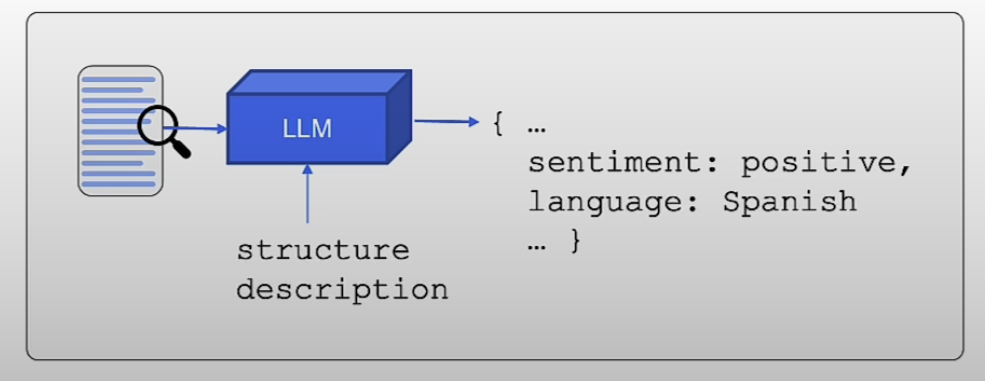

圖示表達

- LLM 接收一段「結構描述」（例如預期的輸出格式或 schema）與輸入文字。
- 輸出會是一段 JSON 格式的結構化結果，例如：

```json
{
  "sentiment": "positive",
  "language": "Spanish"
}
```

## Extraction
- 當給定一個 JSON schema 作為輸入時，LLM 已被微調以能夠找出並填入該 schema 所需的參數
- 這項能力不限於函數 schema，也可用於各類通用資料擷取任務

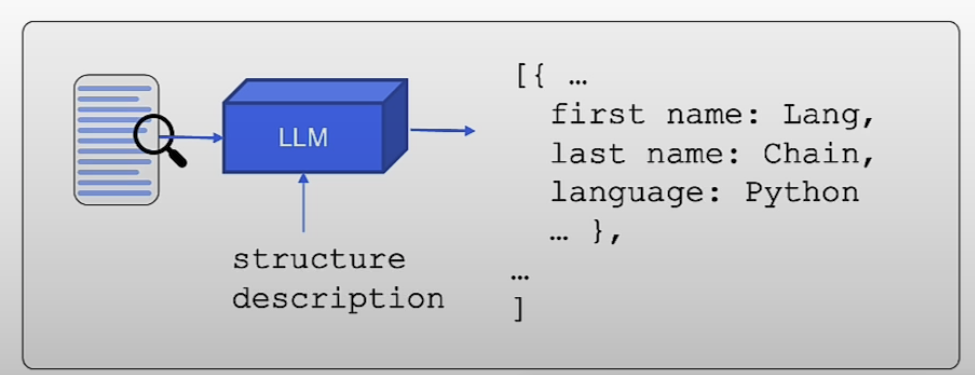

圖示表達

- LLM 接收結構描述（schema）與文字內容。
- 輸出為一組物件的清單，例如：

```json
[
  {
    "first name": "Lang",
    "last name": "Chain",
    "language": "Python"
  }
]

```

In [2]:
from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

In [3]:
class Tagging(BaseModel):
    """Tag the piece of text with particular info."""
    sentiment: str = Field(description="sentiment of text, should be `pos`, `neg`, or `neutral`")
    language: str = Field(description="language of text (should be ISO 639-1 code)")

In [6]:
convert_pydantic_to_openai_function(Tagging)

{'name': 'Tagging',
 'description': 'Tag the piece of text with particular info.',
 'parameters': {'properties': {'sentiment': {'description': 'sentiment of text, should be `pos`, `neg`, or `neutral`',
    'type': 'string'},
   'language': {'description': 'language of text (should be ISO 639-1 code)',
    'type': 'string'}},
  'required': ['sentiment', 'language'],
  'type': 'object'}}

In [5]:
from langchain.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

llm = ChatOllama(temperature=0.0, model="llama3.2")

In [7]:
tagging_functions = [convert_pydantic_to_openai_function(Tagging)]

In [8]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Think carefully, and then tag the text as instructed"),
    ("user", "{input}")
])

In [16]:
model_with_functions = llm.bind_tools(tagging_functions
)

In [17]:
tagging_chain = prompt | model_with_functions

In [18]:
tagging_chain.invoke({"input": "I love langchain"})

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-30T08:53:56.240148819Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6394725503, 'load_duration': 4070264501, 'prompt_eval_count': 211, 'prompt_eval_duration': 1293592214, 'eval_count': 24, 'eval_duration': 1025740056, 'model_name': 'llama3.2'}, id='run--05d5e750-6326-4559-8667-fb6439f41feb-0', tool_calls=[{'name': 'Tagging', 'args': {'language': 'eng', 'sentiment': 'pos'}, 'id': '469385fe-f4dd-4c93-9114-0ce51bb26258', 'type': 'tool_call'}], usage_metadata={'input_tokens': 211, 'output_tokens': 24, 'total_tokens': 235})

In [19]:
tagging_chain.invoke({"input": "我喜歡 LLM"})

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-30T08:55:31.861416327Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1172950042, 'load_duration': 21371433, 'prompt_eval_count': 212, 'prompt_eval_duration': 80304769, 'eval_count': 25, 'eval_duration': 1069608055, 'model_name': 'llama3.2'}, id='run--f193c933-538c-4dbc-a6c4-78a8163c0058-0', tool_calls=[{'name': 'Tagging', 'args': {'language': 'zh-CN', 'sentiment': 'pos'}, 'id': '524d8b2e-9ff8-4a2e-a290-25cf77b8469c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 212, 'output_tokens': 25, 'total_tokens': 237})

## Extraction

In [20]:
from typing import Optional
class Person(BaseModel):
    """Information about a person."""
    name: str = Field(description="person's name")
    age: Optional[int] = Field(description="person's age")

In [22]:
class Information(BaseModel):
    """Information to extract."""
    people: List[Person] = Field(description="List of info about people")

In [23]:
convert_pydantic_to_openai_function(Information)

{'name': 'Information',
 'description': 'Information to extract.',
 'parameters': {'properties': {'people': {'description': 'List of info about people',
    'items': {'description': 'Information about a person.',
     'properties': {'name': {'description': "person's name", 'type': 'string'},
      'age': {'anyOf': [{'type': 'integer'}, {'type': 'null'}],
       'description': "person's age"}},
     'required': ['name', 'age'],
     'type': 'object'},
    'type': 'array'}},
  'required': ['people'],
  'type': 'object'}}

In [25]:
extraction_functions = [convert_pydantic_to_openai_function(Information)]
extraction_model = llm.bind_tools(extraction_functions)

In [26]:
extraction_model.invoke("Joe is 30, his mom is Martha")

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-30T09:01:45.97755881Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5053399392, 'load_duration': 2139226897, 'prompt_eval_count': 216, 'prompt_eval_duration': 1283858822, 'eval_count': 37, 'eval_duration': 1629318029, 'model_name': 'llama3.2'}, id='run--a9430873-f21c-4a3e-8c4d-74f66f58ce7d-0', tool_calls=[{'name': 'Information', 'args': {'people': [{'name': 'Joe', 'age': 30}, {'name': 'Martha'}]}, 'id': '9b0809b3-0d79-4c40-b6e0-abc33de888ac', 'type': 'tool_call'}], usage_metadata={'input_tokens': 216, 'output_tokens': 37, 'total_tokens': 253})

In [27]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the relevant information, if not explicitly provided do not guess. Extract partial info"),
    ("human", "{input}")
])

In [28]:
extraction_chain = prompt | extraction_model

In [30]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha and age is 55"})

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-30T09:03:01.61837971Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1965237457, 'load_duration': 11226876, 'prompt_eval_count': 237, 'prompt_eval_duration': 90818065, 'eval_count': 42, 'eval_duration': 1861896513, 'model_name': 'llama3.2'}, id='run--2181c178-7c8e-4040-8251-1d33d538b667-0', tool_calls=[{'name': 'Information', 'args': {'people': [{'name': 'Joe', 'age': 30}, {'name': 'Martha', 'age': 55}]}, 'id': 'ef16d9e0-578e-4c90-a859-55fbe05ae5cc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 237, 'output_tokens': 42, 'total_tokens': 279})